# pyfabric example 02: fabric tensor of trabecular bone of the proximal femur - comparison of scans with different spatial resolution

Created on:  25.10.2021 <br />
Last update: 09.04.2023 <br />

![](2000L_crop_imgaussfilt_101micron_uint8_YZ_fabric.png)

## Configuration

In [1]:
import os
import sys
# sys.path.insert(0, os.path.abspath('../'))
sys.path.append('/home/gianthk/PycharmProjects/recon_utils')
sys.path.append('/home/gianthk/PycharmProjects/pyfabric')

In [2]:
import pyfabric
import recon_utils as ru

astropy module not found
olefile module not found


In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io

# import imageio

# from scipy import ndimage, misc
# from skimage.filters import threshold_otsu, gaussian
# from skimage import measure, morphology

# from ciclope import pybonemorph as pbm
# import pygalmesh

In [4]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

In [5]:
%%html
<style>
table {float:left}
</style>

#### Read input data

In [7]:
input_file_HR = '/media/gianthk/My Passport/Data/TacoSound/XtremeCT-II/00_resampled_data/2019_L/C0001524.mhd'
input_dir_QCT_DCM = '/media/gianthk/My Passport/Data/TacoSound/QCT/QCTFEMUR_2019L/Q_CT_DIAGBILANZ_HR_0003'
input_file_QCT = '/media/gianthk/My Passport/Data/TacoSound/QCT/QCTFEMUR_2019L/slices/slice_0000.tif'

In [16]:
# Read 3D data
data_3D_QCT = ru.read_tiff_stack(input_file_QCT)
vs = [0.3005, 0.293, 0.293] # [Z, Y, X][mm]

# data_3D_QCT = imageio.v2.volread(input_dir_QCT, format='.dcm')

In [12]:
data_3D_QCT.shape

(636, 512, 512)

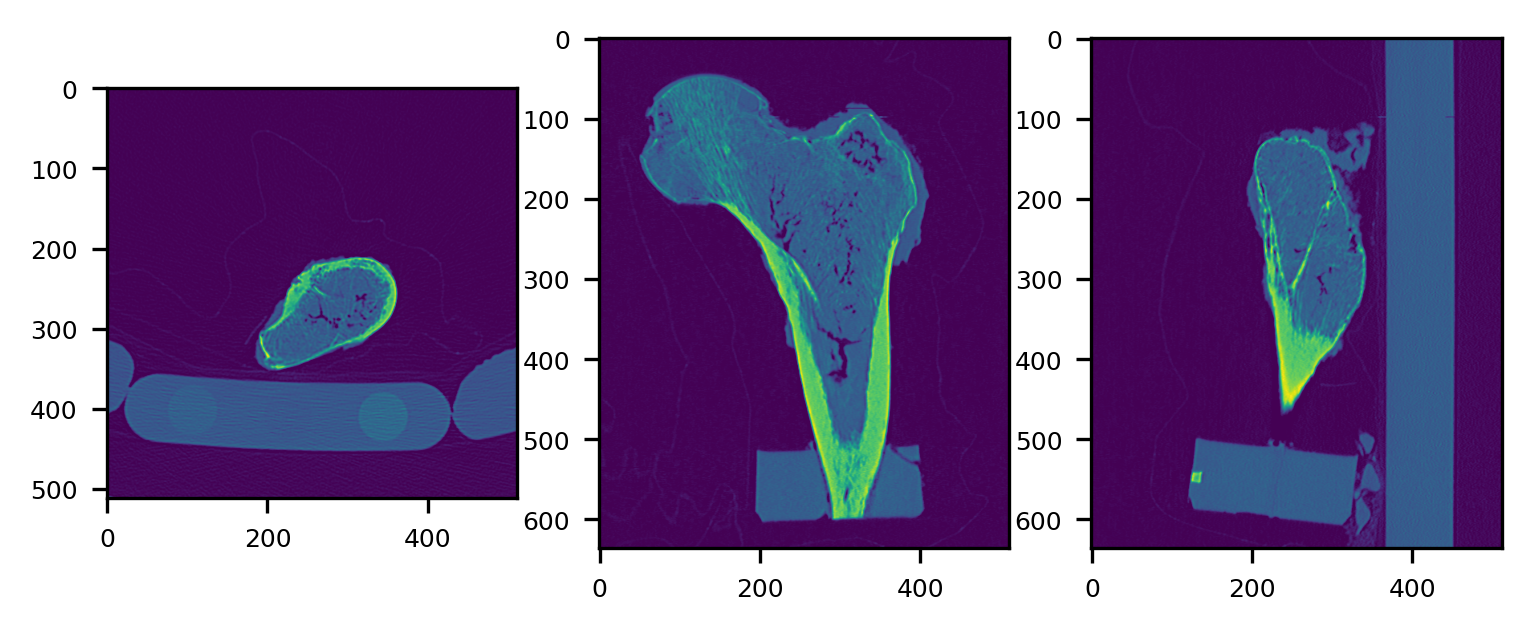

In [14]:
# Inspect dataset
ru.plot_midplanes(data_3D_QCT)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [19]:
data_3D = io.imread(input_file_HR, plugin='simpleitk')

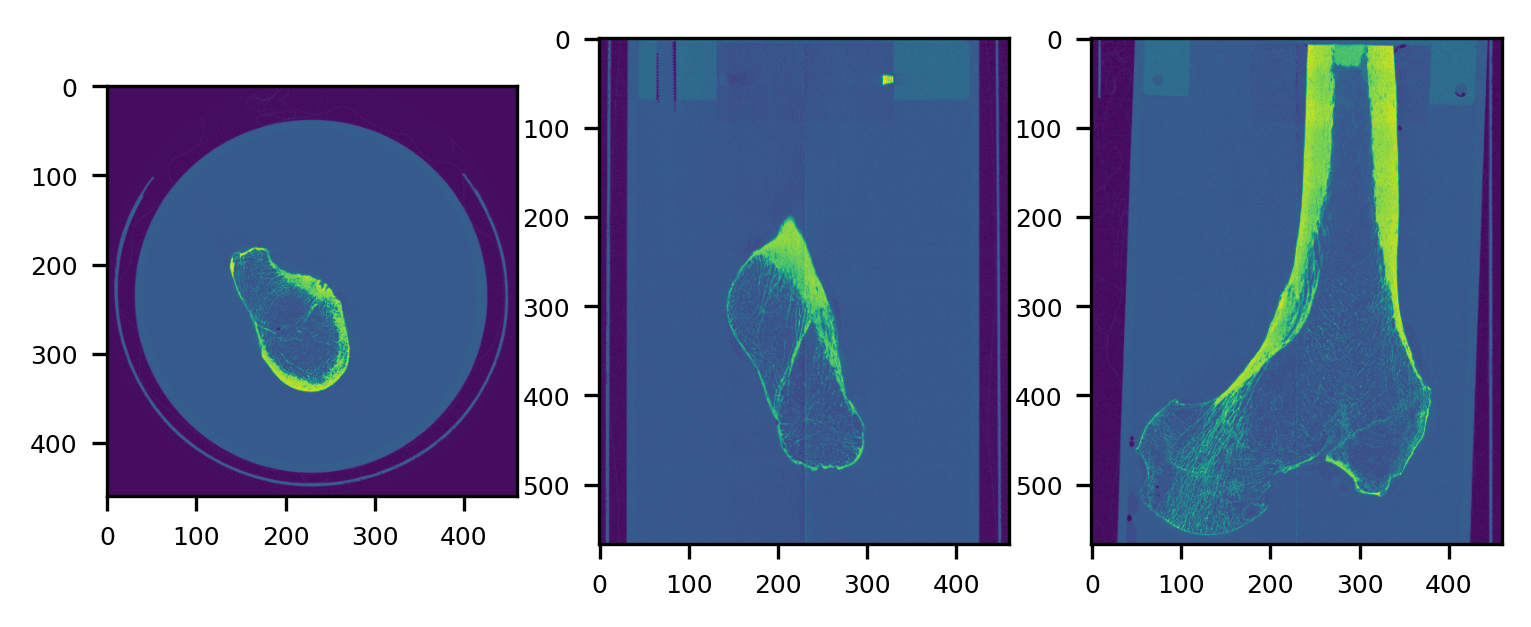

In [20]:
# Inspect dataset
ru.plot_midplanes(data_3D)
plt.show()

In [21]:
import itk
from itkwidgets import view
viewer = view(data_3D, ui_collapsed=True)
viewer.interpolation = False

ModuleNotFoundError: No module named 'itk'

In [ ]:
# launch itk viewer
viewer

### Thresholding

In [7]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 142


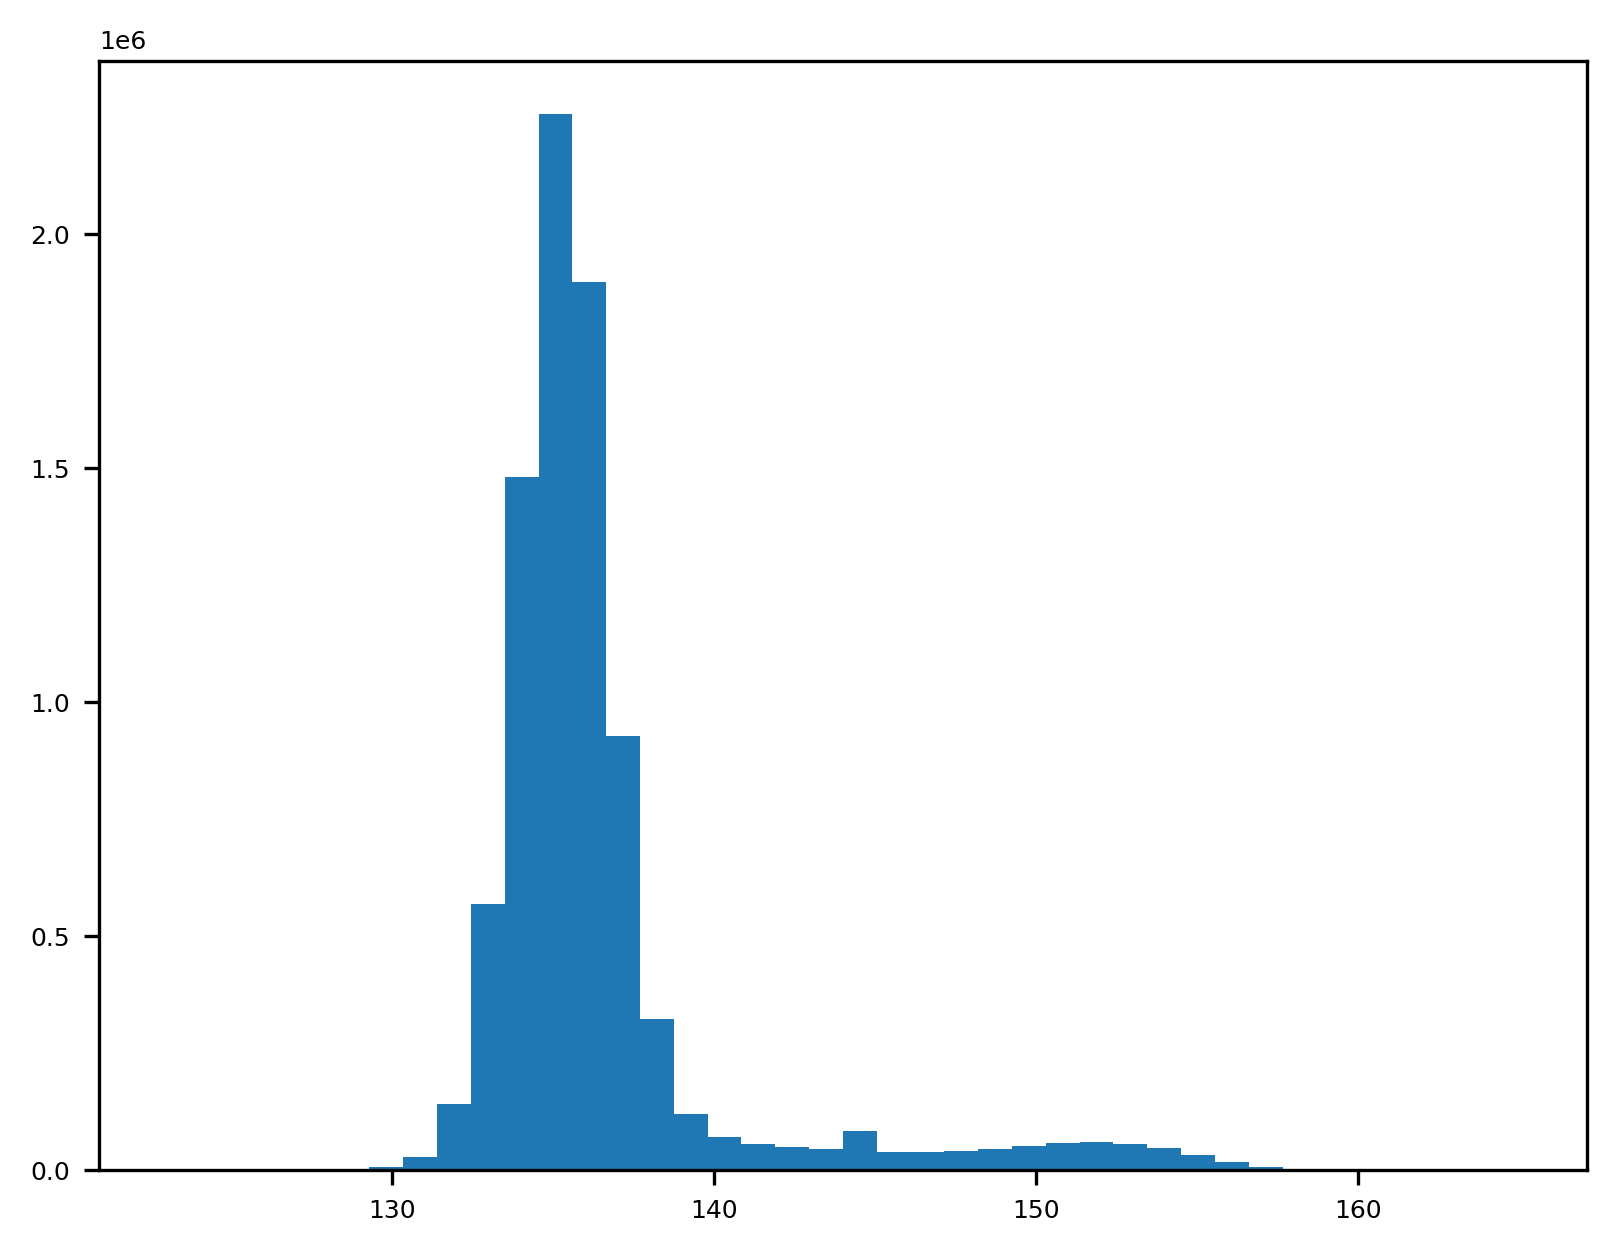

In [8]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

In [7]:
# apply the threshold
# BW = data_3D > T
BW = data_3D > 142

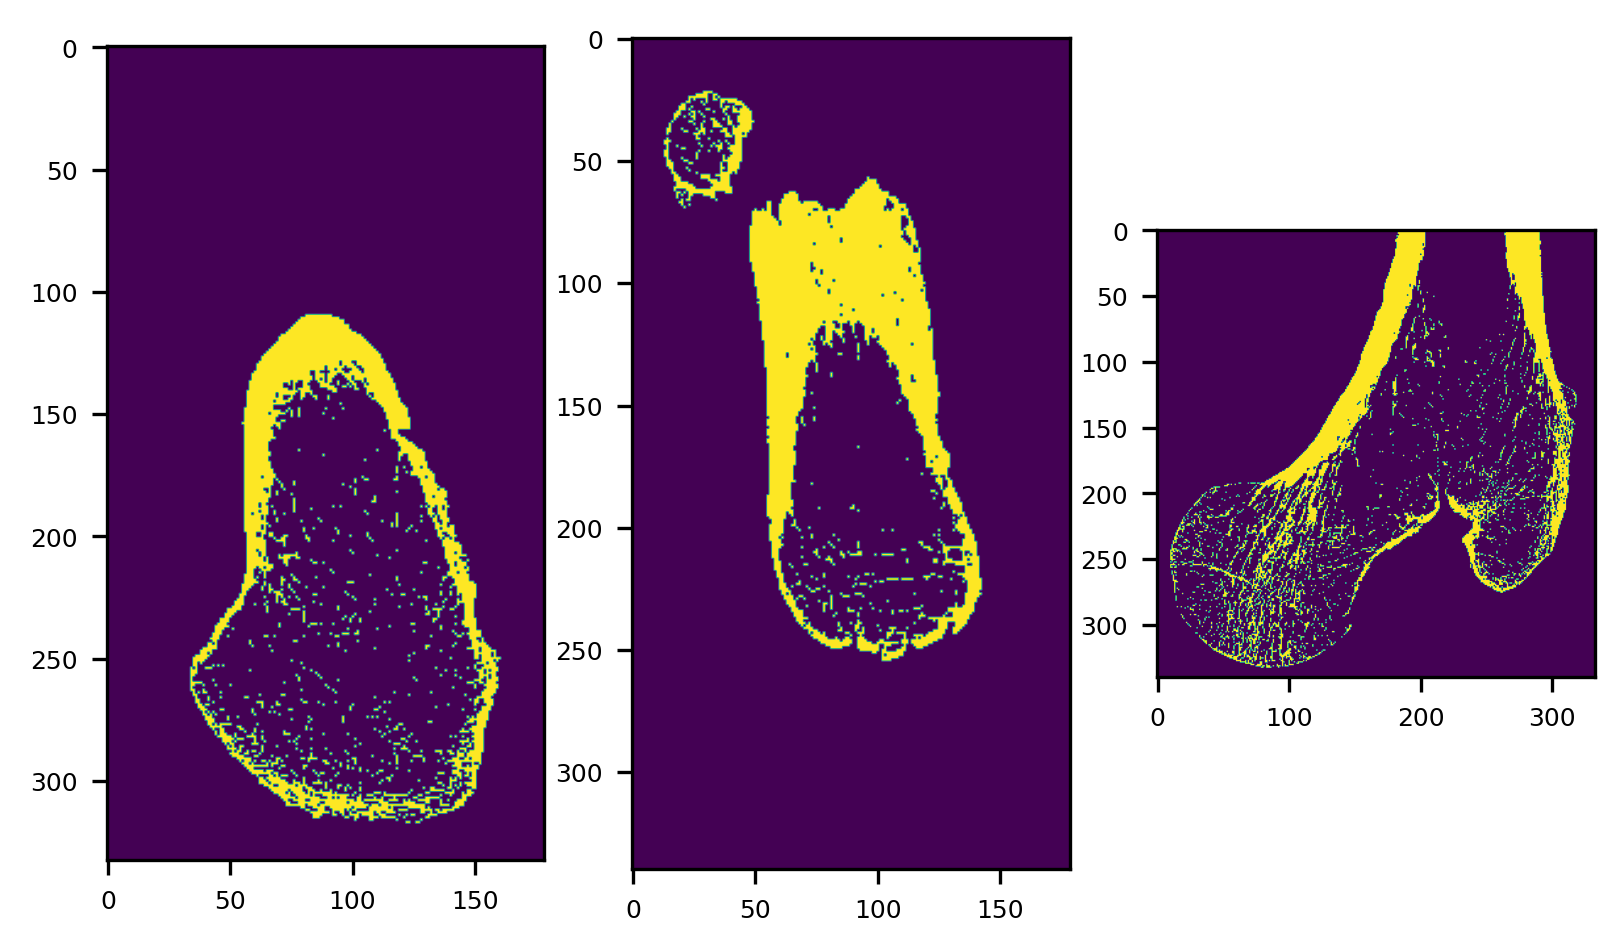

In [7]:
# Inspect binary mask
plot_midplanes(BW)
plt.show()

### Whole bone mask (periosteum mask)

In [8]:
BW_peri = pbm.periosteummask(BW, closepixels=8, closevoxels=10, remove_objects_smaller_than=1, removeunconn=True, verbose=True)

INFO:root:Preliminary removal of objects smaller than 1 pixels.
INFO:root:2D slice-wise image closing and filling.
 Structuring element DISK of radius: 8
100%|██████████| 340/340 [00:03<00:00, 86.08it/s]
INFO:root:Removing isolated clusters of voxels.
INFO:root:Final 3D image closing.
 Structuring element CUBE of radius: 8


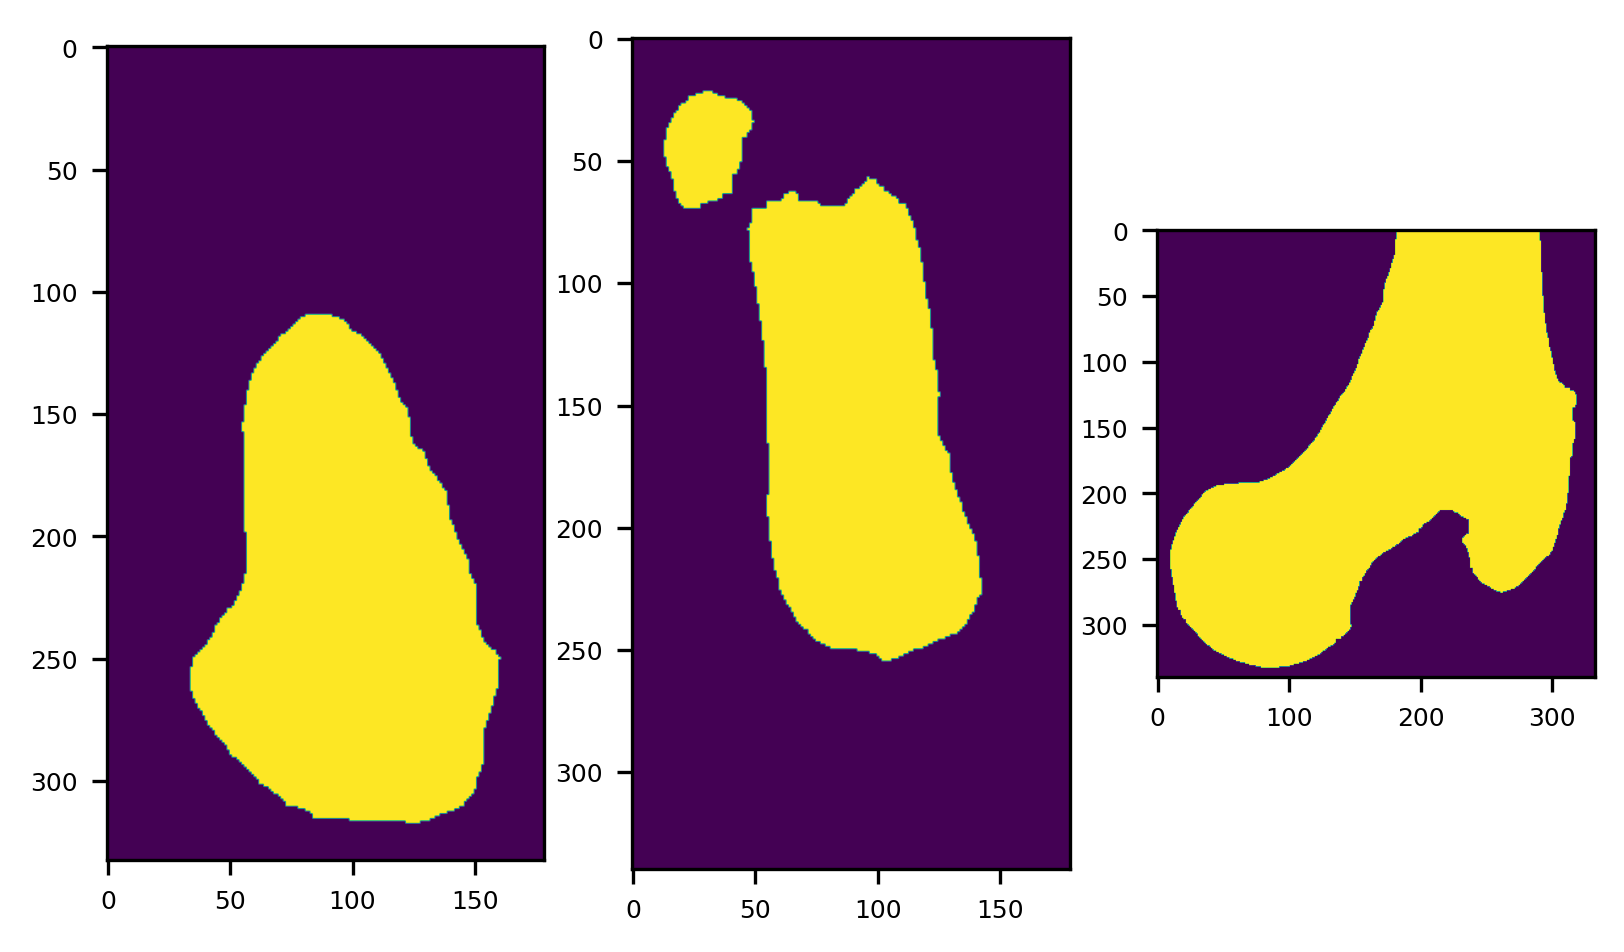

In [20]:
# Inspect whole bone mask
plot_midplanes(BW_peri)
plt.show()

### Cortical and trabecular bone masks
Not implemented yet.. we erode the whole bone mask instead to obtain a tentative mesh of the trabecular core

In [9]:
BW_trab = morphology.binary_erosion(BW_peri, morphology.cube(15))

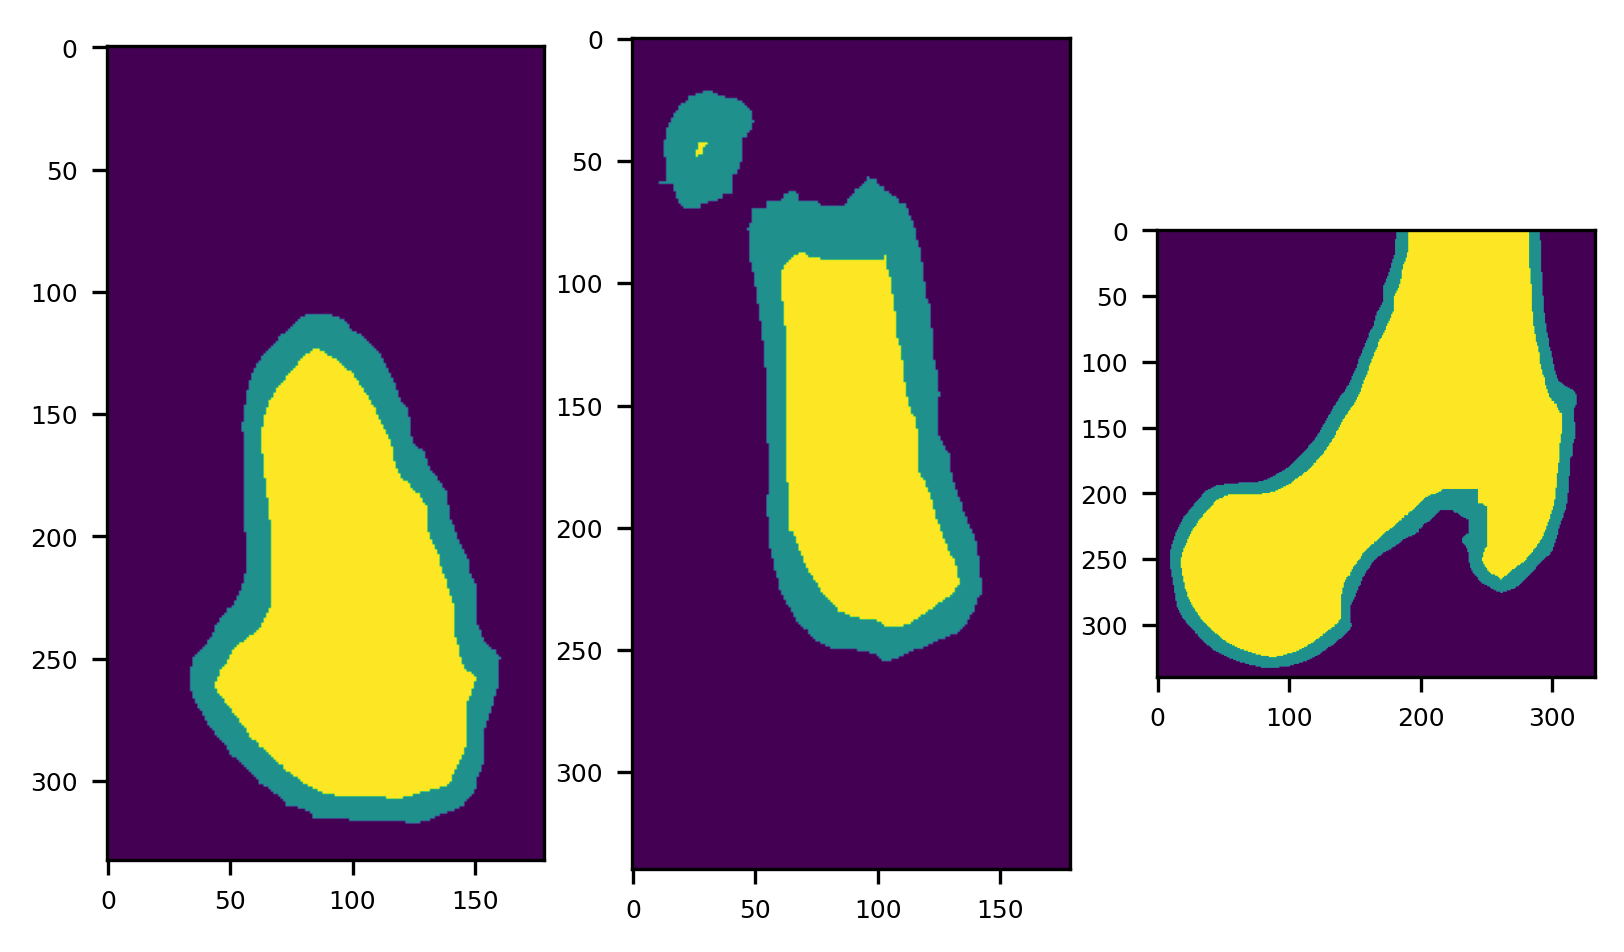

In [10]:
# Inspect mask
plot_midplanes(BW_trab.astype('int')+BW_peri.astype('int'))
plt.show()

In [23]:
import napari
viewer = napari.view_image()

/home/gianthk/anaconda3/envs/CT2FE/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


## Meshing
### Create tetrahedra mesh of trabecular core
Volume meshing is done using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [11]:
# min_facet_angle=20,  lloyd=True,
mesh_trab = pygalmesh.generate_from_array(np.transpose(BW_trab, [2, 1, 0]).astype('uint8'), tuple(vs), max_facet_distance=3*min(vs), max_cell_circumradius=10*min(vs))

Remove triangles

In [12]:
mesh_trab.remove_lower_dimensional_cells()

{'triangle'}

Write VTK mesh with [meshio](https://github.com/nschloe/meshio)

In [6]:
filename_mesh_out = '/home/gianthk/PycharmProjects/CT2FE/test_data/trabecular_bone/2000L_crop_imgaussfilt_101micron_uint8.vtk'

In [14]:
mesh_trab.write(filename_mesh_out)

Read the mesh if you have already generated it and want to start the notebook from this point

In [7]:
import meshio
mesh_trab = meshio.read(filename_mesh_out)

#### Get Barycenter of each cell

In [8]:
# cells barycenter coordinates
cells_bary = np.sum(mesh_trab.points[mesh_trab.cells[0][1][:]], 1)/mesh_trab.points[mesh_trab.cells[0][1][:]].shape[1]

### Extract fabric tensor at cells barycenters
Run this section on high-resolution data!

| ver | runtime |
|-----|---------|
| `to01(ROIACF)>ACF_threshold` | 04:38<00:00, 51.14it/s |
| `envelope(to01andbinary(ROIACF, ACF_threshold))` | 04:15<00:00, 55.66it/s |

In [9]:
# pyfabric ACF parameters
ROIsize = 40
ACF_threshold=0.33
ROIzoom=True
zoom_size=20
zoom_factor=2

In [10]:
evecs, radii, evals, fabric_comp, DA = pf.fabric_pointset(data_3D, cells_bary/vs[0], ROIsize, ACF_threshold, ROIzoom, zoom_size, zoom_factor)

100%|██████████| 14245/14245 [04:40<00:00, 50.75it/s]


In [12]:
radii

array([[        nan,         nan,         nan],
       [ 9.90674675,  4.73293189,  5.72433169],
       [10.16406614, 24.24828642, 16.88221127],
       ...,
       [ 9.73916168,  6.00466116,  5.49465592],
       [        nan,         nan,         nan],
       [11.00348331,  4.76023998,  5.98669061]])

In [11]:
radii = np.abs(radii)

Remove potential outliers based on the ellipsoid radii: \
any ellipsoid with a radius > `ROIsize/2` is suspicious and therefore we remove it

In [21]:
radii[np.any(radii>ROIsize*zoom_factor/2, axis=1),:] = np.nan
# radii[np.any(radii<-ROIsize*zoom_factor/2, axis=1),:] = np.nan
# try zoom_size instead of ROIsize

Also ellipsoid radii < 1 voxel are meaningless

In [13]:
radii[np.any(radii<1, axis=1),:] = np.nan
# radii[radii==0] = 0.001

Check histogram of local fabric ellipsoid radii 

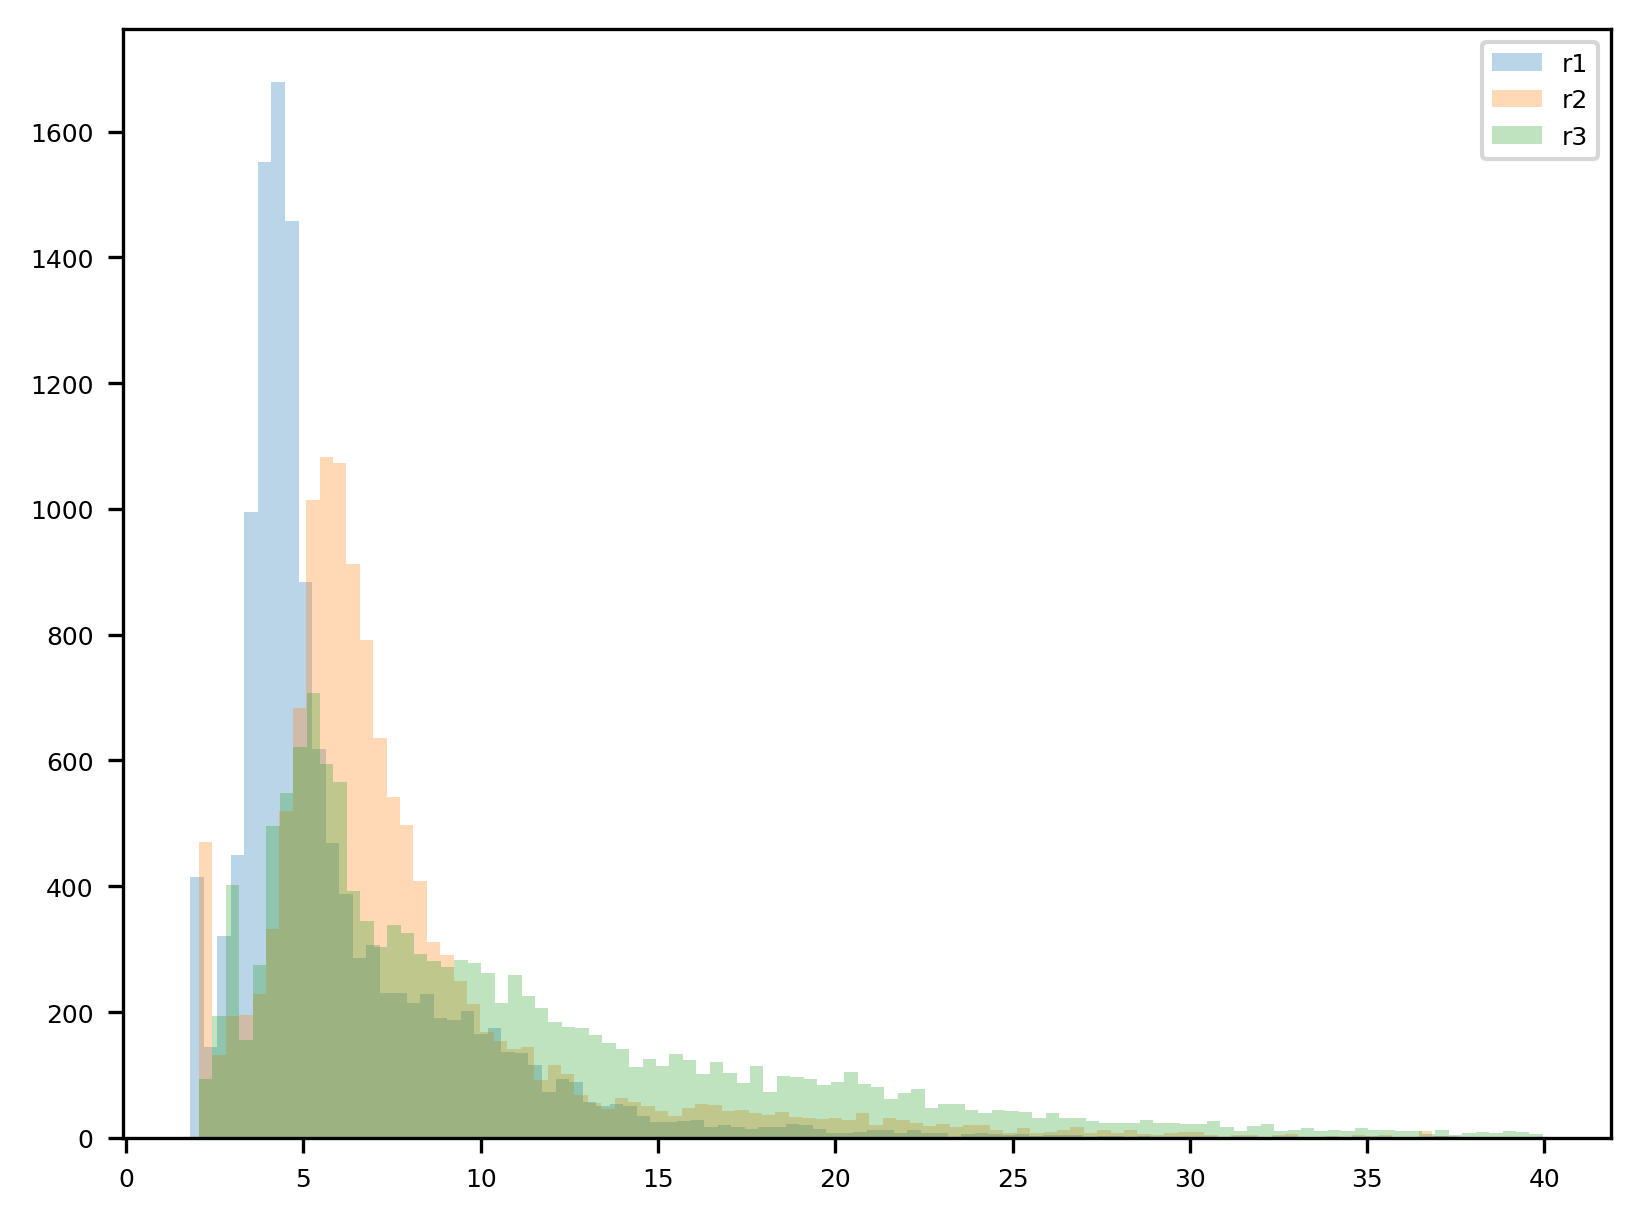

In [11]:
fig2, ax2 = plt.subplots()

plt.hist(radii[:,0].ravel(), alpha=0.3, bins=100, label='r1')
plt.hist(radii[:,1].ravel(), alpha=0.3, bins=100, label='r2')
plt.hist(radii[:,2].ravel(), alpha=0.3, bins=100, label='r3')
# plt.hist(radii.ravel(), alpha=0.4, bins=100)
plt.legend(loc='upper right')
plt.show()

#### Compute local Degree of Anisotropy (DA) as the ratio between major and minor ellipsoid axes

In [23]:
DA = np.nanmax(radii, 1)/np.nanmin(radii, 1)

<ipython-input-23-93a7727f8753>:1: RuntimeWarning: All-NaN slice encountered
  DA = np.nanmax(radii, 1)/np.nanmin(radii, 1)


Take a look at the distribution of DA

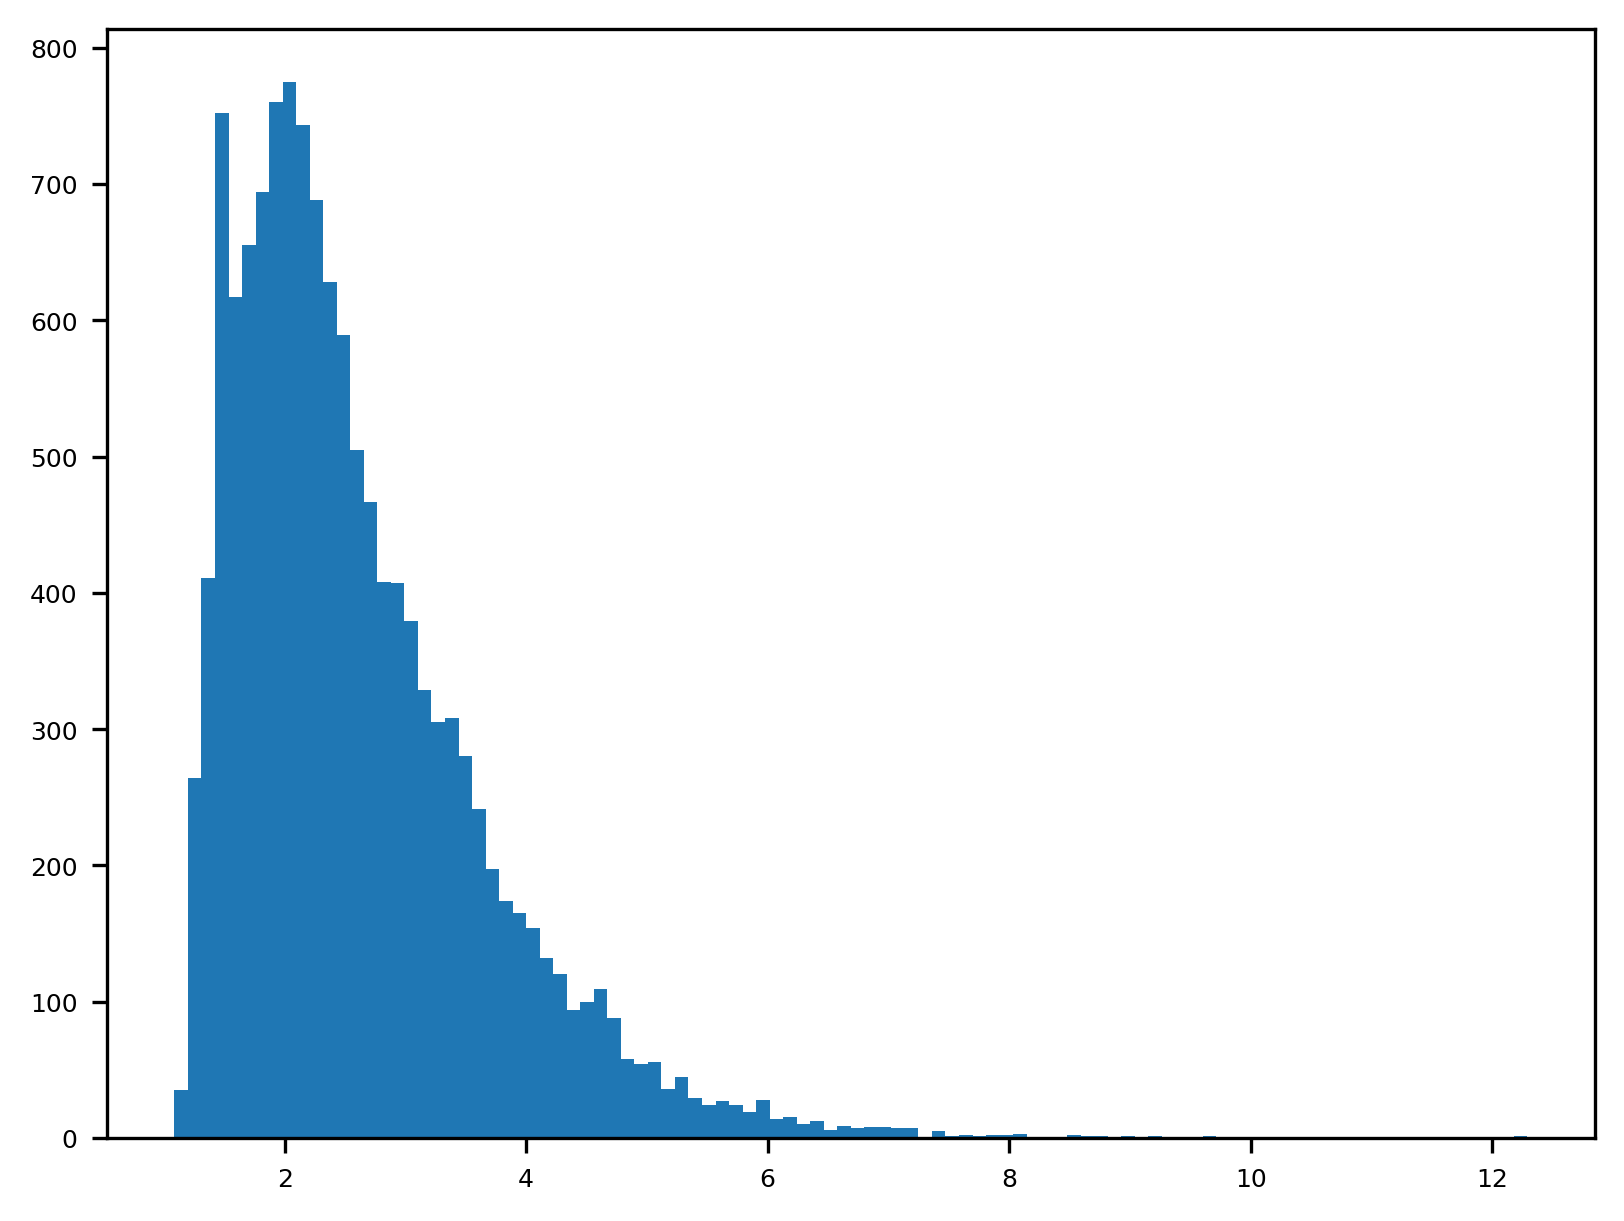

In [12]:
fig2, ax2 = plt.subplots()
plt.hist(DA.ravel(), bins=100, label='r1')
plt.show()

#### Compute ellipsoid tensor components from its eigenvectors and radii
Compute ellipsoid eigenvalues

In [26]:
evals = 1/(radii**2)

Ellipsoid eigen-decomposition: get rank-2 symmetric ellipsoid tensor from evals and evecs <br/>
see: https://www.researchgate.net/publication/265500937_Visualization_of_3D_tensor_fields_derived_from_seismic_images \
Symmetric tensor components are expected to have the following order: **XX, YY, ZZ, XY, YZ, XZ**

In [27]:
fabric_tens = np.ndarray(evecs.shape)
fabric_comp = np.ndarray([evecs.shape[0], 6])
for cell in range(0,evecs.shape[0]):
    fabric_tens[cell,:,:] = np.matmul(evecs[cell,:,:], np.matmul((evals[cell,:]*np.identity(3)), np.transpose(evecs[cell,:,:])))
    fabric_comp[cell,:] = fabric_tens[cell,[0, 1, 2, 0, 1, 0],[0, 1, 2, 1, 2, 2]]

In [ ]:
fabric_tens = np.ndarray(evecs.shape)
fabric_comp = np.ndarray([evecs.shape[0], 6])
for cell in range(0, evecs.shape[0]):
    fabric_tens[cell, :, :] = np.matmul(evecs[cell, :, :], np.matmul((evals[cell, :] * np.identity(3)), np.transpose(evecs[cell, :, :])))
    fabric_comp[cell, :] = fabric_tens[cell, [2, 1, 0, 1, 0, 0], [2, 1, 0, 2, 1, 2]]
    evecs[cell, :, :] = np.flipud(evecs[cell, :, :])

In [ ]:
evecs[2,:,:]

In [36]:
evals[2,:]

array([0.01054598, 0.033115  , 0.02773336])

In [45]:
cell=8700
np.matmul(evecs[cell,:,:], np.matmul((evals[cell,:]*np.identity(3)), np.transpose(evecs[cell,:,:])))

array([[ 0.04811848, -0.00238167, -0.00438218],
       [-0.00238167,  0.04550131,  0.00257427],
       [-0.00438218,  0.00257427,  0.03952043]])

In [40]:
evals[2,:]*np.identity(3)

array([[0.01054598, 0.        , 0.        ],
       [0.        , 0.033115  , 0.        ],
       [0.        , 0.        , 0.02773336]])

Attach fabric cell data

In [13]:
mesh_trab.cell_data={'evec1': evecs[:,:,0], 'evec2': evecs[:,:,1], 'evec3': evecs[:,:,2], 'radii': radii, 'fabric': fabric_comp, 'DA': DA}

Rewrite mesh with fabric data

In [14]:
filename_mesh_out = '/home/gianthk/PycharmProjects/CT2FE/test_data/trabecular_bone/2000L_crop_imgaussfilt_101micron_uint8_fabric.vtk'

In [15]:
mesh_trab.write(filename_mesh_out)